# Projet Recherche Opérationelle - Branch And Bound

## Importation des modules

Nous importons tout d'abord tous les modules nécessaires dans ce projet. Nous utilisons les modules classiques __numpy__ et __matplotlib (pyplot)__. Nous utilisons égalements les modules __networkx__ et un module particulier de pydot (cellule pour installation ci dessous) lors de la visualisation de parcours de l'arbre de branchement.

In [1]:
conda install pydot

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [256]:
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
import copy

## Structure de données

*Nous définissons un certain nombre de structures de données, primordiales pour l'implémentation de l'algorithme de Branch and Bound.*

### Les noeuds 

Chaque noeud de l'arbre de branchement sera un objet. Chaque objet Noeud créé possède :
* Un indexe : __idx__
* Un noeud parent : __parent__
* Une liste de noeuds enfants : __children__
* Une borne duale associée (lower bound ici, puisqu'il s'agit d'un problème de minimisation) : __lb__
* Une liste de noeuds visités : __visited__.
* Une méthode d'affichage.

Dans cette première partie, les index de noeuds seront des entiers, leur stockage sera rapide. Dans la partie __affichage__ les index seront des chaines de caractères plus ou moins longues, leur stockage sera légèrement plus long.

__Exemple__

![Arbre de branchement](EX2.png)

En considérant que les noeud en vert on déjà été visités et que les noeuds rouges ne l'ont pas été, le noeud 1 représenté ci dessus possèderait (selon la structure choisie) les éléments suivants : 
* __parent__=0
* __children__=[ 4 , 5 ]
* __visited__=[ 0 ]

In [257]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

### Fonctions abroresence et computeCost

*Nous implémentons à présent un certain nombre de fonctions que nous utiliserons lors de l'implémentation de l'algorithme de branch and bound.*

La première fonction est une fonction arborescence. Elle nous permet de donner une branche complète d'arbre de branchement en partant d'une feuille. Dans l'__exemple__ ci-dessus, la fonction : __arborescence(4,Tree)__ renverrait : [4,1,0]. 

In [258]:
def arborescence(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node.idx)
        node = node.parent
    branch.append(node.idx)
    
    return branch

Afin de déterminer facilement le cout d'une solution donnée, nous implémentons une méthode générale computeCost. A partir des données du problème (p,d,w) et d'un ordre de taches à effectuer, la fonction renvoie le cout de la solution.

In [259]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

Afin de tester la dernière méthode nous utilisons le problème vu en TD (*exercice 7, TD branch and bound*) dont les instances sont rappelées ci-dessous : 

* unités de temps pour que les pièces soient usinées : p=[12,8,15,9]
* date auxquelles les pièces doivent être prêtes : d=[16,26,25,27]
* pénalités de retard : w=[4,5,3,5]

In [260]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

La solution que nous testons (ordre d'usinage : [0,1,3,2]) est la solution optimale, obtenue lors du TD. Son coût vaut 67. On vérifie donc que la fonction computeCost nous donne bien 67 avec cet ordre d'usinage.

In [261]:
computeCost(p,d,w,[0,1,3,2])

67

### Calculs de bornes primales

L'idée de ce projet est de tester différentes composantes de l'algorithme de Branch and Bound, afin de voir leur impact sur les performances de l'algorithme. 

Nous nous concentrons tout d'abord sur le calcul des bornes primales. Le calcul de borne primale s'effectue au début de l'algorithme. Plus le calcul est fin, i.e plus la borne primale obtenue possède une valeur faible, plus l'algorithme ira vite. L'idée est donc d'essayer de trouver la méthode la plus interessante.


Nous avons fait le choix de coder différentes fonctions :
* __getPrimal_0__ : nous calculons une solution en usinant les pièces selon l'ordre croissant des dates d'usinage au plus tard.
* __getPrimal_1__ : nous calculons une solution en usinant les pièces selon l'ordre croissant des (dates d'usinage au plus tard-le temps d'usinage)$*$pénalité

Comme les premières pièces engendrent le moins de retard, nous nous sommes dit qu'il est possible d'obtenir une meilleure borne primale en réflechissant à la position des derniers éléments. Cela nous a amené à la fonction : 
* __getPrimal_2__ : nous calculons une solution en mettant à la dernière position disponible l'élément non traité donnant lieu à la plus petite pénalité de retard.

In [262]:
def getPrimal_0(p,d,w):
    sortedTasks=np.argsort(d)
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_1(p,d,w):
    sortedTasks=(np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_2(p,d,w):
    tasksLeft=[int(i) for i in range(len(p))]
    order=[]
    while len(tasksLeft)!= 0:
        time=np.sum(np.array(p)[tasksLeft])
        penalities=(time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks=np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

Nous comparons à présent les résultats de ces méthodes en utilisant les instances p,d,w initialisée ci dessus (*EX7 TD branch and bound*). __Rappel__: plus une fonction de calcul de borne duale est performante, plus la valeur de la borne duale trouvée est petite.

In [263]:
print("Temps production : ", p)
print("Date limite :      ", d)
print("Pénalités :        ", w)
print("0 : ",getPrimal_0(p,d,w))
print("1 : ",getPrimal_1(p,d,w))
print("2 : ",getPrimal_2(p,d,w))

Temps production :  [12, 8, 15, 9]
Date limite :       [16, 26, 25, 27]
Pénalités :         [4, 5, 3, 5]
0 :  (136, array([0, 2, 1, 3]))
1 :  (133, array([3, 1, 2, 0]))
2 :  (67, [0, 1, 3, 2])


__Conclusion :__ la méthode getPrimal_2 est bien plus performante que les méthodes 0 et 1.

### Calcul des bornes duales

In [264]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

def getDual_1(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    return dual

def getDual_2(p,d,w,visited):
    dual=0
    time=np.sum(p)

    for i in visited:
        retard=(time-d[i])
        dual+=retard*w[i]*(retard>0)
        time-=p[i]
        
    return dual

In [265]:
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : \n",
      getDual_0(p,d,w,[2,3]))
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : \n",
      getDual_1(p,d,w,[2,3]))

Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : 
 110
Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : 
 0


### Méthodes d'exploration

In [266]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

def exploration_2(Queue,Tree,UB):
    bestNode = None
    bestLB = -math.inf
    for i in range(len(Queue)):
        if Tree[Queue[i]].lb > bestLB and Tree[Queue[i]].lb < UB:
            bestLB = Tree[Queue[i]].lb
            bestNode = i
    return(Queue[i])

# Branch and Bound

In [267]:
def branch_and_bound_display(p,d,w,byLast,getPrimal,getDual,exploration,steps):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)
    if steps:
        print("First UB : ", UB)
    
    root = Node(0,None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        

        # process the first node in the queue

        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if nbIterations == 1e4:
            print("UB : ", UB)
            print(currentNode)
        if nbIterations == 2e5:
            print("UB : ", UB)
            print(currentNode)
        if nbIterations == 2e5:
            print("UB : ", UB)
            print(currentNode)
        
        if steps:
            print("##################################")
            print("Current Node : {}\n".format(currentIndex),currentNode )
        
        if len(currentNode.visited) == len(p):
            order = copy.copy(currentNode.visited)
            if byLast:
                order.reverse()
            solutionCost = computeCost(p,d,w,order)
            if solutionCost <= UB:
                UB = solutionCost
                currentOrder=order
                
        if currentNode.lb < UB:
            for nextTask in (set(Tasks)-set(currentNode.visited)):
                nextVisited = copy.copy(currentNode.visited)
                nextVisited.append(nextTask)
                nextLb = getDual(p,d,w, nextVisited)
                
                newNode = Node(len(Tree)-1,currentNode, [], nextLb,nextVisited)
                Tree.append(newNode)
                Queue.append(len(Tree)-1)
                currentNode.children.append(newNode)
        else:
            if steps:
                print("Prune : ", currentIndex)
        
        # Calculate the current LB as the maximum of all the upper bounds among the active nodes
        currentLB = -math.inf
        for node in Tree:
            if node.lb > currentLB and node.lb <= UB:
                currentLB = node.lb
        
        # Update the LB if the current LB is better
        if currentLB >= LB:
            LB = currentLB
        
        # Display the current upper and lower bounds    
        if steps:
            print("LB= ",LB," UB= ", UB)
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    print("Number of iterations : ", nbIterations)
    
    return UB, currentOrder

## Visualisation de l'arbre de branchement.

L'idée est ici d'implémenter une fonction de visualisation de l'arbre de branchement. 

### Redéfinition de quelques éléments de structure

Comme évoqué aupravant, nous changeons les index des noeuds. Nous sommes conscients que stocker des entiers est moins couteux en temps de calcul que stocker des grandes chaines de caractères et c'est pour cette raison que nous avons fait une nouvelle version de la fonction branch and bound ci dessous. 

Afin de mieux comprendre notre facon d'indexer les noeuds, nous présentons un exemple succinct. 

![Arbre de branchement](EX1.png)

* Le noeud racine sera __P__
* Le noeud __P(1)__ signifie que la solution liée à ce noeud place l'usinage de la pièce 1 en dernier.
* Le noeud __P(2,1)__ signifie que la solution liée à ce noeud place l'usinage de la pièce 1 en dernier, puis celui de la pièce 2 en avant dernier.

Pour des exmples de taille plus conséquente (+ de taches), par exemple 5, certains des noeuds seront instanciés par __P(*4 chiffres séparés par des virgules*)__.

### Branch and bound redéfini

Nous utilisons ces nouvelles indexations pour mettre à jour la fonction branch and bound. 

Notons aussi que nous ajoutons quelques élements de code permettant de trouver la branche de l'arbre qui aura donné lieu à la meilleure solution. Pour cela, nous localisons le meilleur noeud, i.e le noeud qui :
* est tel que la borne duale du noeud est inférieure ou égale à la borne primale du problème                **(1)**
* est tel que la borne duale du noeud est plus grande que n'importe quel borne duale des noeuds vérifiant (1).

Nous remontons ensuite (en utilisant les parents) afin d'obtenir la branche de l'arbre donnant lieu à la meilleure solution. Cela nous sera utile lors de la visualisation de l'arbre de branchement.

Les éléments retournés par la fonction sont également ajustés. Nous ajoutons le retour de : 
* __branch__ : la branche donnant lieu à la solution optimale du problème
* __Tree__: l'arbre correspondant au problème

In [268]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)

    bestNode = Node("",-1, [], 0 ,[])
    
    root = Node("P",None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        
        # process the first node in the queue

        currentIndex = exploration(Queue,None,None)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if currentNode.lb < UB:
            
            if len(currentNode.visited) == len(p):
                order = currentNode.visited.copy()
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder=order
                    bestNode = currentNode
            else:
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = currentNode.visited.copy()
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node("",currentNode, [], nextLb,nextVisited)
                    
                    if currentNode.visited!=[]:
                        newNode.idx="P("
                        for i in range(len(nextVisited)-1):
                            newNode.idx+=str(nextVisited[i])+","
                        newNode.idx+=str(nextVisited[len(nextVisited)-1])+")"
                    else:
                        newNode.idx="P("+str(nextTask)+")"
                        
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(newNode)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if 2*(UB-bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

### Fonction d'affichage de l'arbre

Nous implémentons à présent une fonction d'affichage de l'arbre. Cette méthode utilise différents élements de packages spécifiques (importés au préalable, et non utilisés jusqu'alors). Nous utilisons :
* __networkx__ afin de crééer une structure d'arbre facile d'utilisation et facile à représenter.
* __pydot__ qui permettra de visualiser simplement l'abre de branchement.

La méthode consiste principalement à reconstitué l'arbre de branchement à partir de la liste de Noeud __Tree__. De l'afficher de manière adequat, et de mettre en évidence la branche donnant lieu à la solution optimale.

In [269]:
def displayTree(Tree,currentOrder,branch,byLast):
    
    index=['P']
    parent=['P']
    for node in Tree:
        if(node.idx!="P"):
            index.append(node.idx)
            parent.append((node.parent).idx)
    graphe=dict(zip(index,parent))
    
    graph=nx.Graph()
    graph.add_nodes_from(index)
    for idx in graphe.keys():
        graph.add_edge(idx,graphe[idx])
        
    if(byLast==True):
        branch.reverse()

    bestPath= set(zip(branch[:-1], branch[1:]))
    edge_colors=dict()
    for edge in graph.edges():
        if edge in bestPath:
            edge_colors[edge]='red'
        else:
            edge_colors[edge]='lightblue'
            
    node_colors=dict()
    for node in graph.nodes():
        if node in branch:
            node_colors[node]='red'
        else:
            node_colors[node]="lightblue"
    
    plt.figure(figsize=(12,8))
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos,with_labels=True,node_size=1200,node_color=node_colors.values(),edge_color=edge_colors.values())
    plt.show()

### Test de la fonction d'affichage

Nous effectuons le test de notre fonction d'affichage. Pour cela, nous prenons différents problèmes. Dans un premier temps, nous utiliserons l'exemple de TD (*EX7 TD Branch and bound*). Nous comparons ensuite l'abre de branchement affiché à celui obtenu lors de la résolution du branch and bound en TD.

In [270]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


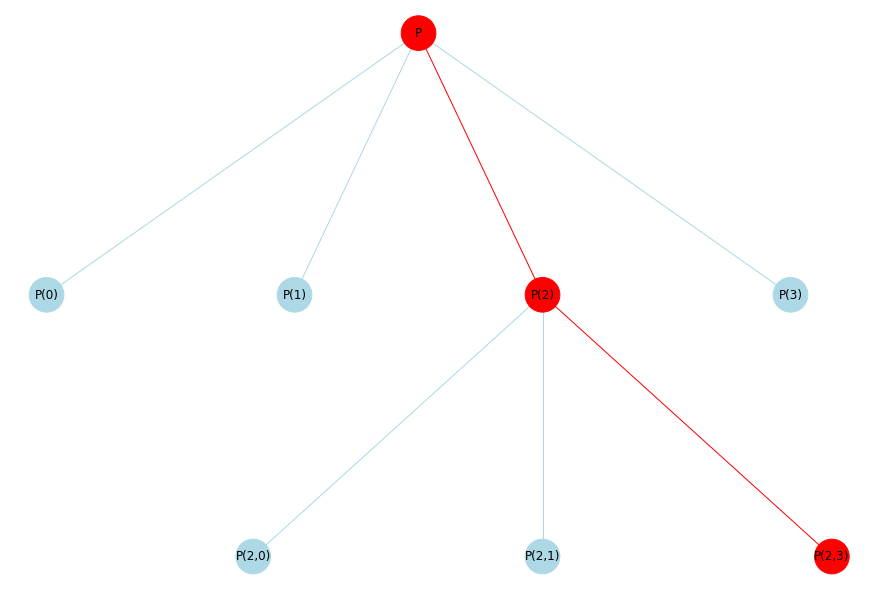

In [271]:
solution,order,nbIterations,branch,Tree=branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
displayTree(Tree,order,branch,True)


__Commentaires :__ nous voyons ici les noeuds ayant donné lieu à des élagages et la branche ayant donné lieu à la solution optimale. Les noeuds P(0), P(1), et P(3) on donné lieu à des élagages. Les noeuds P(2,0) et P(2,1) également. Le noeud P(2,3) a quant a lui permis de trouver la solution optimale puisque sa borne duale vaut la borne primale du problème (67).

In [272]:
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, False, getPrimal_1, getDual_1,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, False, getPrimal_2, getDual_1,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_1, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_1, getDual_2,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_0, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_0, getDual_2,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_1)
print(nbIterations)

65
59
38
17
44
17
8
8


## Test de notre fonction Branch-And-Bound : 

In [254]:
def genInstancies(n):
    p=np.random.randint(1,15,n)
    d=np.random.randint(3,int(0.5*n*15),n)
    w=np.random.randint(1,5,n)
    return(p,d,w)

In [255]:
p,d,w = genInstancies(6)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
print(branch)
displayTree(Tree,order,branch,True)


p :  [13 10 14  6  5  5]
d :  [ 9 28 21 34  3 33]
w :  [3 4 4 3 4 4]


NameError: name 'getDual_2' is not defined

In [273]:
p,d,w = genInstancies(15)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))

p :  [10  8 10  6  4  9  1  9  6 10  5 10  1  7  5]
d :  [  5  56  80  11  83  92  25  90  64  86 104  93  87  82  98]
w :  [2 2 4 4 2 2 2 3 1 1 1 1 2 4 4]


KeyboardInterrupt: 

# PLNE

In [39]:
from pulp import *
import time

In [243]:
def plne_Ordonnancement(p,d,w):
    
    Tasks=range(len(p)) #Liste des taches 
    
    # Declaration du modèle
    model = LpProblem("Ordonnancement", LpMinimize)
    
    # Variables 
    x = LpVariable.dicts("x", ((i, j) for i in Tasks for j in Tasks),0,1,LpInteger) #x_{i,j}=1 si i est usinée avant j
    f= LpVariable.dicts("f",Tasks,0,None,LpInteger) # f_j = date de fin d'usinage de la pièce j 
    r= LpVariable.dicts("r",Tasks,0,None,LpInteger) #r_j = retard lié à la pièce j (forcément positif)
    
    # Contraintes :
    for j in Tasks:
        model+= f[j]==p[j]+lpSum(p[i]*x[i,j] for i in Tasks)-p[j]*x[j,j]
        model+= r[j]>=f[j]-d[j]  #retard >= fin d'usinage - date de rendu souhaite
        
    #Contraintes d'ordre    
    for i in Tasks : 
        for j in range(i) : 
            model+= x[i,j]+x[j,i]==1 #Si i avant j alors j est après i 
            for k in Tasks:
                model+= x[i,k]>= x[i,j]+x[j,k]-1 #Transitivité
    
    
    # Objectif : 
    model+=lpSum(w[i]*r[i] for i in Tasks) #Minimisation des pénalités de retard
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD())
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    
        
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    print("Ordre des taches =",order)
    return(solveTime)

In [244]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

plne_Ordonnancement(pj,dj,wj)

Temps de résolution =  0.04710102081298828
Statut de la solution =  Optimal
Valeur optimale =  67.0
Ordre des taches = [0 1 3 2]


0.04710102081298828

In [252]:
p,d,w = genInstancies(4,.5)

In [253]:
branch_and_bound(p,d,w, True, getPrimal_2, getDual_3,exploration_1)

NameError: name 'Node' is not defined